In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("21027_Statistics_AmeriFlux16.dat")

df.columns

Index(['TIMESTAMP_START', 'TIMESTAMP_END', 'ALB', 'NETRAD', 'SW_IN', 'SW_OUT',
       'LW_IN', 'LW_OUT', 'T_CANOPY', 'T_SI111_body', 'PPFD_IN', 'VWC_1_1_1',
       'Ka_1_1_1', 'T_1_1_1', 'BulkEC_1_1_1', 'VWC_1_2_1', 'Ka_1_2_1',
       'T_1_2_1', 'BulkEC_1_2_1', 'VWC_1_3_1', 'Ka_1_3_1', 'T_1_3_1',
       'BulkEC_1_3_1', 'VWC_1_4_1', 'Ka_1_4_1', 'T_1_4_1', 'BulkEC_1_4_1',
       'VWC_1_5_1', 'Ka_1_5_1', 'T_1_5_1', 'BulkEC_1_5_1', 'VWC_1_6_1',
       'Ka_1_6_1', 'T_1_6_1', 'BulkEC_1_6_1', 'VWC_1_7_1', 'Ka_1_7_1',
       'T_1_7_1', 'BulkEC_1_7_1', 'VWC_1_8_1', 'Ka_1_8_1', 'T__1_8_1',
       'BulkEC_1_8_1', 'VWC_1_9_1', 'Ka_1_9_1', 'T_1_9_1', 'BulkEC_1_9_1',
       'WS', 'WD', 'LWmV_1_1_1', 'LWMDry_1_1_1', 'LWMCon_1_1_1',
       'LWMWet_1_1_1', 'LWmV_1_1_2', 'LWMDry_1_1_2', 'LWMCon_1_1_2',
       'LWMWet_1_1_2'],
      dtype='object')

# Estimating Ground Heat Flux and Thermal Conductivity from SoilVue Data

## **Initial Ground Heat Flux Calculation**
To estimate ground heat flux (\(G\)) in \(W/m^2\) from the SoilVue soil moisture probe data, we used:

$$
G = -\lambda \frac{\Delta T}{\Delta z}
$$

Where:
- $G =$ ground heat flux $(W/m^2)$
- $\lambda =$ soil thermal conductivity $(W/mK)$
- $\Delta T =$ temperature difference between two depths $(K)$
- $\Delta z =$ depth difference $(m)$

We computed \(G\) for different depth pairs and displayed the results.

---

## **Thermal Conductivity from Time Lag**
Thermal conductivity $(\lambda)$ was estimated using the **thermal diffusivity approach**, which relies on the time lag between temperature variations at different depths.

$$
\alpha = \frac{\lambda}{\rho c}
$$

Using the time lag $(\Delta t)$ between peaks at two depths:

$$
\alpha = \frac{(z_2 - z_1)^2}{\pi \Delta t}
$$

Then:

$$
\lambda = \alpha \cdot \rho c
$$

---

## **Refined Analysis with Visual Confirmation**
By plotting the **ground heat flux (G\)**, we visually confirmed that the peaks were **about 120 minutes apart** rather than multiple days. Using this corrected time lag:

$$
\alpha = \frac{(0.05 \text{ m})^2}{\pi \times 7200 \text{ s}}
$$

$$
\lambda = \alpha \times 2.0 \times 10^6 \text{ J/m³K}
$$

---

## **Refining with Soil Moisture Data**
Since **volumetric heat capacity** depends on soil moisture (\(\theta\)), we refined it using:

$$
\rho c = \rho_c^{\text{dry}} + \theta \cdot \rho_c^{\text{water}}
$$

Where:
- $\rho_c^{\text{dry}} = 1.0 \times 10^6 J/m³K (dry soil)$
- $\rho_c^{\text{water}} = 4.18 \times 10^6 J/m³K (water)$
- $\theta = VWC (unitless, 0 to ~0.5)$

This produced **time-varying thermal conductivity** values based on soil moisture.

---

## **Conclusion**
- Computed **ground heat flux** using SoilVue probe data.
- Identified and corrected an **overestimated time lag**.
- Refined **thermal conductivity** estimates using **soil moisture-dependent heat capacity**.

These refinements improve **soil energy balance modeling** and can be used for **land surface heat transfer studies**.



<Axes: xlabel='datetime'>

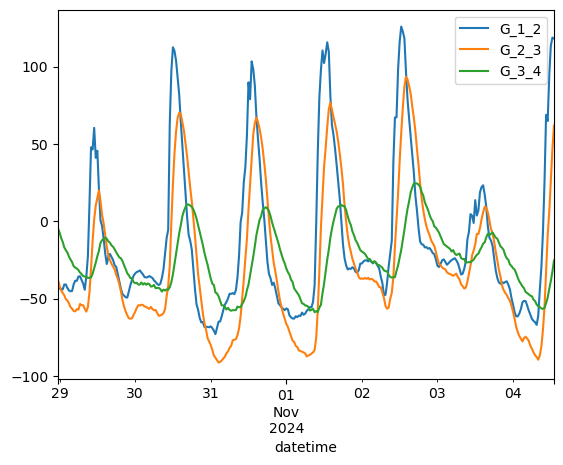

In [5]:
 # Extract column names to identify soil temperature and moisture variables
columns = df.columns

# Filter for soil temperature and volumetric water content variables
temp_columns = [col for col in columns if col.startswith("T_1_")]
vwc_columns = [col for col in columns if col.startswith("VWC_1_")]

# Display identified columns

# Define depths in meters (corresponding to temperature and VWC columns)
depths_cm = [5, 10, 20, 30, 40, 50, 60, 75, 100]  # Expected depths
depths_m = np.array(depths_cm) / 100  # Convert to meters

# Ensure we only process available depths in the dataset
available_depths = [int(col.split("_")[2]) for col in temp_columns]
available_depths_m = np.array(available_depths) / 100

# Empirical model for estimating soil thermal conductivity (Johansen model approximation)
def estimate_thermal_conductivity(vwc):
    """
    Estimate thermal conductivity (W/mK) based on volumetric water content (VWC).
    Using an empirical relationship where conductivity increases with moisture.
    """
    lambda_dry = 0.25  # Typical dry soil thermal conductivity (W/mK)
    lambda_sat = 2.5   # Typical saturated soil thermal conductivity (W/mK)
    return lambda_dry + (lambda_sat - lambda_dry) * vwc

# Compute temperature gradient and ground heat flux
G_list = []
for i in range(len(available_depths) - 1):
    z1, z2 = available_depths_m[i], available_depths_m[i + 1]
    T1, T2 = df[temp_columns[i]], df[temp_columns[i + 1]]
    vwc_avg = (df[vwc_columns[i]] + df[vwc_columns[i + 1]]) / 2  # Average VWC for thermal conductivity
    
    # Estimate thermal conductivity
    lambda_soil = estimate_thermal_conductivity(vwc_avg)
    
    # Compute temperature gradient
    dT_dz = (T2 - T1) / (z2 - z1)
    
    # Compute ground heat flux (G)
    G = -lambda_soil * dT_dz  # W/m²
    G_list.append(G)

# Combine results into a DataFrame
G_df = pd.DataFrame(G_list).T  # Transpose to match time-series format
G_df.columns = [f"G_{available_depths[i]}_{available_depths[i+1]}" for i in range(len(available_depths) - 1)]

# Merge with timestamp for reference
G_df["TIMESTAMP"] = df["TIMESTAMP_START"]
G_df["datetime"] = pd.to_datetime(G_df["TIMESTAMP"],format="%Y%m%d%H%M")
G_df = G_df.set_index('datetime')
G_df[["G_1_2","G_2_3","G_3_4"]].plot()


In [11]:
G_df[["G_1_2","G_2_3","G_3_4"]].round(3).to_clipboard()

In [6]:
# Identify soil moisture (VWC) columns in the dataset
vwc_columns_new = [col for col in df.columns if col.startswith("VWC_1_")]

# Extract VWC for the selected depths (2 cm and 3 cm)
vwc_5cm = df[vwc_columns_new[1]]  # VWC at 2 cm
vwc_10cm = df[vwc_columns_new[2]]  # VWC at 3 cm
vwc_20cm = df[vwc_columns_new[3]]

# Compute average VWC
vwc_avg = (vwc_5cm + vwc_10cm) / 2

# Define constants for dry soil and water heat capacity
heat_capacity_dry = 1.0e6  # J/m³K
heat_capacity_water = 4.18e6  # J/m³K

# Compute refined heat capacity
heat_capacity_refined = heat_capacity_dry + (vwc_avg * heat_capacity_water)

# Given time lag and depth difference
corrected_time_lag_seconds = 120 * 60  # Convert minutes to seconds
corrected_depth_diff_m = 0.05  # 1 cm in meters

# Compute corrected thermal diffusivity
corrected_alpha = (corrected_depth_diff_m ** 2) / (np.pi * corrected_time_lag_seconds)

# Compute corrected thermal conductivity
corrected_lambda = corrected_alpha * heat_capacity_refined

# Output the revised estimates
print(np.median(corrected_lambda))



0.12210711887355205


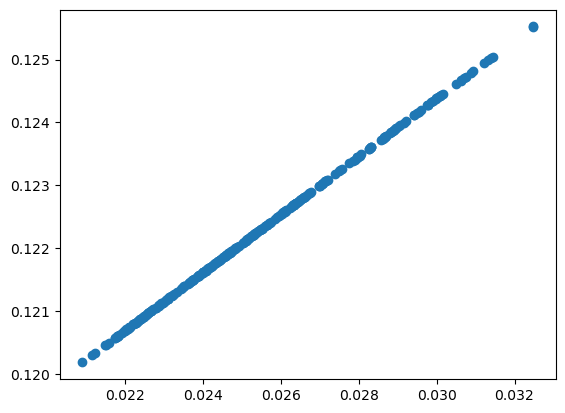

In [7]:
plt.scatter(vwc_avg, corrected_lambda)

In [9]:
df#['VWC_1_1_1']

,TIMESTAMP_START,TIMESTAMP_END,ALB,NETRAD,SW_IN,SW_OUT,LW_IN,LW_OUT,T_CANOPY,T_SI111_body,...,WS,WD,LWmV_1_1_1,LWMDry_1_1_1,LWMCon_1_1_1,LWMWet_1_1_1,LWmV_1_1_2,LWMDry_1_1_2,LWMCon_1_1_2,LWMWet_1_1_2
0,202410282330,202410290000,0.00000,-85.74638,-0.902583,0.040889,257.2221,342.0250,4.324737,7.069883,...,2.900254,281.8558,266.8754,100.00000,0.0,0.000000,268.7237,100.0,0.0,0.0
1,202410290000,202410290030,0.00000,-79.13544,-0.767361,0.042306,263.6420,341.9678,4.513260,6.316626,...,3.143894,278.1910,267.1759,100.00000,0.0,0.000000,269.1077,100.0,0.0,0.0
2,202410290030,202410290100,0.00000,-80.08758,-0.811583,-0.035361,263.9327,343.2440,4.706057,6.965338,...,2.752384,287.2395,267.0380,100.00000,0.0,0.000000,268.8788,100.0,0.0,0.0
3,202410290100,202410290130,0.00000,-88.16839,-0.911250,-0.013667,256.4900,343.7608,4.648794,7.650538,...,3.089123,282.4929,266.6425,100.00000,0.0,0.000000,268.3956,100.0,0.0,0.0
4,202410290130,202410290200,0.00000,-83.43222,-0.830611,0.038806,264.5235,347.0863,5.419833,8.077590,...,4.725887,278.5977,266.1454,100.00000,0.0,0.000000,267.6849,100.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,202411041100,202411041130,22.39097,127.88260,328.304000,75.300720,229.4426,354.5634,7.653487,6.293955,...,2.430619,278.5589,263.2868,99.72222,0.0,0.277778,264.3221,100.0,0.0,0.0
312,202411041130,202411041200,23.93350,252.91150,526.371500,125.985700,227.8604,375.3348,12.161940,9.471169,...,1.562718,259.0669,261.4109,100.00000,0.0,0.000000,263.6249,100.0,0.0,0.0
313,202411041200,202411041230,24.09812,272.57280,558.391000,134.562300,228.8342,380.0901,12.605790,10.032300,...,1.821330,277.2256,261.0339,100.00000,0.0,0.000000,263.0309,100.0,0.0,0.0
314,202411041230,202411041300,24.22349,284.00750,577.907100,139.988200,229.2270,383.1382,12.928760,10.437600,...,1.963593,232.4496,260.8577,100.00000,0.0,0.000000,262.3393,100.0,0.0,0.0


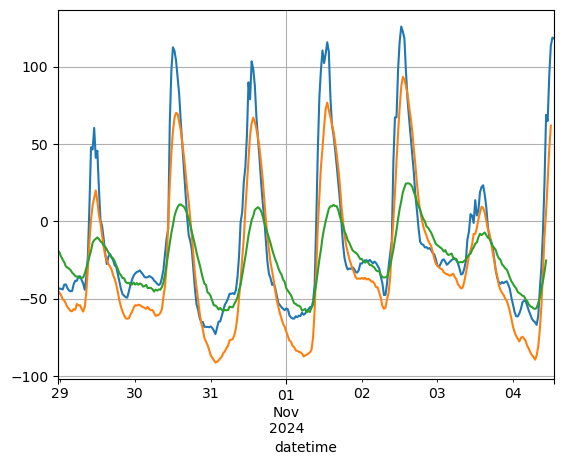

In [23]:
import matplotlib.pyplot as plt
G_df["G_1_2"].plot()
G_df["G_2_3"].shift(-2).plot()
G_df["G_3_4"].shift(-5).plot()
plt.grid()